# Загрузка модулей

In [1]:
# Модель
import optuna as opt
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold

# Пайплайн
from sklearn.pipeline import Pipeline
from helpers.data import DataPreprocessor, CAT_FEATURES
from helpers.validation import valid_predictions

# Данные
import os
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Проверка GPU
from catboost.utils import get_gpu_device_count
TASK_TYPE = 'GPU' if get_gpu_device_count() else 'CPU'

# Отображение
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def make_predictions(model, X_test):
    """ Создание сабмита для AI Challenge """
    # Загрузка сбалансированного датасета
    balanced_df = pd.read_csv(BALANCED_DATASET, index_col=0)
    
    # Обрезка негативных записей до числа позитивных
    first_negatives = balanced_df[balanced_df['y'] == 0][:balanced_df[balanced_df['y'] == 1]['y'].count()]
    balanced_df = pd.concat([balanced_df[balanced_df['y'] == 1], first_negatives])

    # Удаление выбросов
    balanced_df = balanced_df[balanced_df['Длительность'] < 400]
    balanced_df = balanced_df[(balanced_df['Сумма'] > 2) & (balanced_df['Сумма'] < 10)]
    balanced_df = balanced_df[balanced_df['До поставки'] < 300]
    balanced_df = balanced_df[balanced_df['Дней между 0_1'] < 400]
    balanced_df = balanced_df[balanced_df['Количество изменений после согласований'] < 2000]
    balanced_df = balanced_df[balanced_df['Количество'] < 300000]

    X, y = balanced_df.iloc[:, :-1], balanced_df.iloc[:, -1]   
    model.fit(X, y)
    preds = model.predict(X_test)

    save_submission(preds, 'submission')
    
def save_submission(preds, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

# Удаление дубликатов из тренировочной выборки
train_df = train_df.drop_duplicates()

# Разделение выборки на тренировочную и тестовую
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Удаление выбросов из тренировочной выборки
X_train = pd.concat([X_train, y_train], axis=1) # Объединяем X_train и y_train для удаления выбросов только из тренировочной выборки
X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

# Отделяем метки классов от признаков
y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

# Общий датасет для большего числа записей на кросс-валидации
X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [3]:
# Создание оверсемпл-датасета (отбор рандомных записей)
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X_train, y_train)

# Параметры
params = {
    'cat_features': CAT_FEATURES,
    'iterations': 1500, 
    'max_depth': 12,
    'l2_leaf_reg': 0.2,
    'task_type': 'GPU',
    }

# Предобработчик и модель
data_preprocessor = DataPreprocessor(encode_categorical=False)
model = CatBoostClassifier(**params, eval_metric='F1')

# Пайплайн
pipeline = Pipeline([('data_preproc', data_preprocessor),
                     ('model', model)])

In [ ]:
# Запуск кросс-валидации
cv_scores = cross_val_score(pipeline, X_general, y_general, cv=StratifiedKFold(n_splits=5), scoring='f1_macro')
print(f'Mean CV: {cv_scores.mean()}')

In [4]:
# Обучение модели и получение предсказаний для тестовой выборки
pipeline.fit(X_res, y_res)
preds = pipeline.predict(X_test)

0:	learn: 0.8803859	total: 340ms	remaining: 8m 29s
1:	learn: 0.8874866	total: 673ms	remaining: 8m 24s
2:	learn: 0.8889903	total: 989ms	remaining: 8m 13s
3:	learn: 0.8897380	total: 1.3s	remaining: 8m 6s
4:	learn: 0.8925218	total: 1.63s	remaining: 8m 6s
5:	learn: 0.8929725	total: 1.94s	remaining: 8m 3s
6:	learn: 0.8938440	total: 2.26s	remaining: 8m 2s
7:	learn: 0.8943975	total: 2.58s	remaining: 8m 1s
8:	learn: 0.8942818	total: 2.91s	remaining: 8m 2s
9:	learn: 0.8946846	total: 3.23s	remaining: 8m 1s
10:	learn: 0.8953859	total: 3.56s	remaining: 8m 1s
11:	learn: 0.8954977	total: 3.87s	remaining: 7m 59s
12:	learn: 0.8953532	total: 4.18s	remaining: 7m 58s
13:	learn: 0.8956589	total: 4.5s	remaining: 7m 57s
14:	learn: 0.8963374	total: 4.83s	remaining: 7m 58s
15:	learn: 0.8965579	total: 5.16s	remaining: 7m 58s
16:	learn: 0.8972056	total: 5.47s	remaining: 7m 57s
17:	learn: 0.8972438	total: 5.8s	remaining: 7m 57s
18:	learn: 0.8973308	total: 6.13s	remaining: 7m 57s
19:	learn: 0.8980252	total: 6.45s

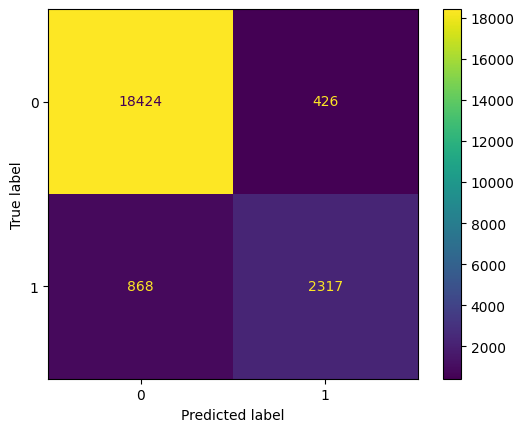

              precision    recall  f1-score   support

           0    0.95501   0.97740   0.96607     18850
           1    0.84470   0.72747   0.78171      3185

    accuracy                        0.94128     22035
   macro avg    0.89985   0.85244   0.87389     22035
weighted avg    0.93906   0.94128   0.93943     22035

F1-macro: 0.8738940220616035
ROC-AUC score: 0.8524365289882532
Accuracy: 0.9412752439301112


In [5]:
# Вывод результатов валидации
valid_predictions(y_test, preds, pipeline.classes_)

In [ ]:
# Предсказание для тестовой выборки AI Challenge
make_predictions(pipeline, test_df)